## Import Packages

In [26]:
# Import necessary packages for the fraud detection model.
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

## Function to **reset** the random number generator seeds for various Python libraries.

In [27]:
def reset_seeds():
    os.environ['PYTHONHASHSEED'] = str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)

## Data Loading

In [28]:
# Reset the random number generator seeds for various Python libraries to ensure reproducible results.
reset_seeds()
bookings_data = pd.read_csv('/content/sample_data/bookings.csv')
bookings_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Data Preprocessing

### Null Value Treatment

In [29]:
# Counting the null values in each column
null_stats = pd.DataFrame(bookings_data.isnull().sum(), columns=['missing_value_count'])
null_stats.loc[:,'% of dataset'] = np.round(null_stats.loc[:,'missing_value_count'] / bookings_data.shape[0] * 100, 2)
null_stats.loc[null_stats.loc[:,'missing_value_count']>0,:].sort_values(by='missing_value_count', ascending=False)

,missing_value_count,% of dataset
company,112593,94.31
agent,16340,13.69
country,488,0.41
children,4,0.00


In [30]:
# As we can see the company column has more than 94% data null. So we can drop that column

bookings_data = bookings_data.drop(['company'], axis=1)

In [31]:
# Treating null values
print(bookings_data['agent'].dtypes)
print(bookings_data['country'].dtypes)
print(bookings_data['children'].dtypes)

# Although agent is categorical value, it is treated as a numerical value. So converting
# agent to the categorical
bookings_data.loc[:,'agent'] = bookings_data.loc[:,'agent'].apply(lambda x: 'A'+str(x).rjust(3, '0'))

# Filling the numerical null values using median
bookings_data['children'] = bookings_data['children'].fillna(bookings_data['children'].median())

# Filling the categorical null values with 'None'
bookings_data['agent'] = bookings_data['agent'].fillna('None')
bookings_data['country'] = bookings_data['country'].fillna('None')

null_stats = pd.DataFrame(bookings_data.isnull().sum(), columns=['missing_value_count'])
null_stats.loc[:,'% of dataset'] = np.round(null_stats.loc[:,'missing_value_count'] / bookings_data.shape[0] * 100, 2)
null_stats.loc[null_stats.loc[:,'missing_value_count']>0,:].sort_values(by='missing_value_count', ascending=False)


float64
object
float64


,missing_value_count,% of dataset


## Feature Processing


In [32]:
X = bookings_data.copy()

# Remove the 'fraud' column from X and assign it to the variable y as a NumPy array.
y = X.pop('is_canceled').to_numpy()

# Display the first few rows of the resulting DataFrame X to ensure the 'fraud' column was successfully removed.
X.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,342,2015,July,27,1,0,0,2,0.0,...,3,No Deposit,Anan,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,737,2015,July,27,1,0,0,2,0.0,...,4,No Deposit,Anan,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,7,2015,July,27,1,0,1,1,0.0,...,0,No Deposit,Anan,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,13,2015,July,27,1,0,1,1,0.0,...,0,No Deposit,A304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,14,2015,July,27,1,0,2,2,0.0,...,0,No Deposit,A240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Encoding features

In [23]:
# Convert categorical variables in X to binary indicator variables using one-hot encoding.
X = pd.get_dummies(bookings_data, drop_first=True)

### Train/Test Split

In [24]:
# Split the data into training, validation, and test sets using the train_test_split() function.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/(1-0.1), random_state=42)

# Display the first few rows of the resulting DataFrame X_train.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(84899, 1507)
(23878, 1507)
(84899,)
(23878,)
(10613, 1507)
(10613,)


### Scaling Features

In [25]:
# Scale the data using the StandardScaler from scikit-learn.
from sklearn.preprocessing import StandardScaler, LabelEncoder
std = StandardScaler()
X_train_scl = std.fit_transform(X_train)
X_val_scl = std.transform(X_val)
X_test_scl = std.transform(X_test)

# Encode the target variable using LabelEncoder from scikit-learn.
lbe = LabelEncoder()
y_train_scl = lbe.fit_transform(y_train)
y_val_scl = lbe.transform(y_val)
y_test_scl = lbe.transform(y_test)

### Balancing the Training Dataset

In [33]:
# Applying the SMOTE (Synthetic Minority Over-sampling Technique) algorithm to balance the class distribution.
# This resampling was done to the training data only
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scl, y_train_scl)

# Calculate the length of the resulting resampled data to confirm that it has been successfully balanced.
len(X_resampled)

# There was a significant increase in the training data.

#Checking the shape of the training set
X_resampled.shape

(106992, 1507)

## Model Building

### Defining the Layers

In [44]:
# Clear the Keras backend session and reset the random number generator seeds.
tf.keras.backend.clear_session()
reset_seeds()

# Define the architecture of the neural network model using the Keras Functional API.
inputs = tf.keras.Input((X_train_scl.shape[1],))

dense_1 = tf.keras.layers.Dense(100, activation='relu')(inputs)
dense_2 = tf.keras.layers.Dense(40, activation='relu')(dense_1)

# As this is a classification model, the sigmoid is used as the activation function
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)

bench_model = tf.keras.Model(inputs=inputs, outputs=outputs)

### Compiling the Model

In [45]:
# Compile the neural network model with the specified optimizer, loss function, and metrics.
bench_model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.0001),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['Accuracy'])

### Running the Model

In [46]:
# Train the neural network model with the specified training data, number of epochs, and batch size.
epochs = 25
batch_size = 64
bench_history = bench_model.fit(X_train_scl, y_train_scl,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(X_val_scl, y_val_scl))

Epoch 1/25
1327/1327 [==============================] - 16s 10ms/step - loss: 0.6851 - Accuracy: 0.5866 - val_loss: 0.6571 - val_Accuracy: 0.6168
Epoch 2/25
1327/1327 [==============================] - 9s 6ms/step - loss: 0.6468 - Accuracy: 0.6401 - val_loss: 0.6258 - val_Accuracy: 0.6654
Epoch 3/25
1327/1327 [==============================] - 7s 5ms/step - loss: 0.6178 - Accuracy: 0.6833 - val_loss: 0.5992 - val_Accuracy: 0.7016
Epoch 4/25
1327/1327 [==============================] - 7s 5ms/step - loss: 0.5919 - Accuracy: 0.7131 - val_loss: 0.5751 - val_Accuracy: 0.7266
Epoch 5/25
1327/1327 [==============================] - 8s 6ms/step - loss: 0.5679 - Accuracy: 0.7366 - val_loss: 0.5524 - val_Accuracy: 0.7484
Epoch 6/25
1327/1327 [==============================] - 7s 5ms/step - loss: 0.5452 - Accuracy: 0.7569 - val_loss: 0.5308 - val_Accuracy: 0.7683
Epoch 7/25
1327/1327 [==============================] - 8s 6ms/step - loss: 0.5234 - Accuracy: 0.7779 - val_loss: 0.5099 - val_Accurac

### Saving the Model

In [47]:
bench_model.save('/content/sample_data/model.h5')

### Evaluation

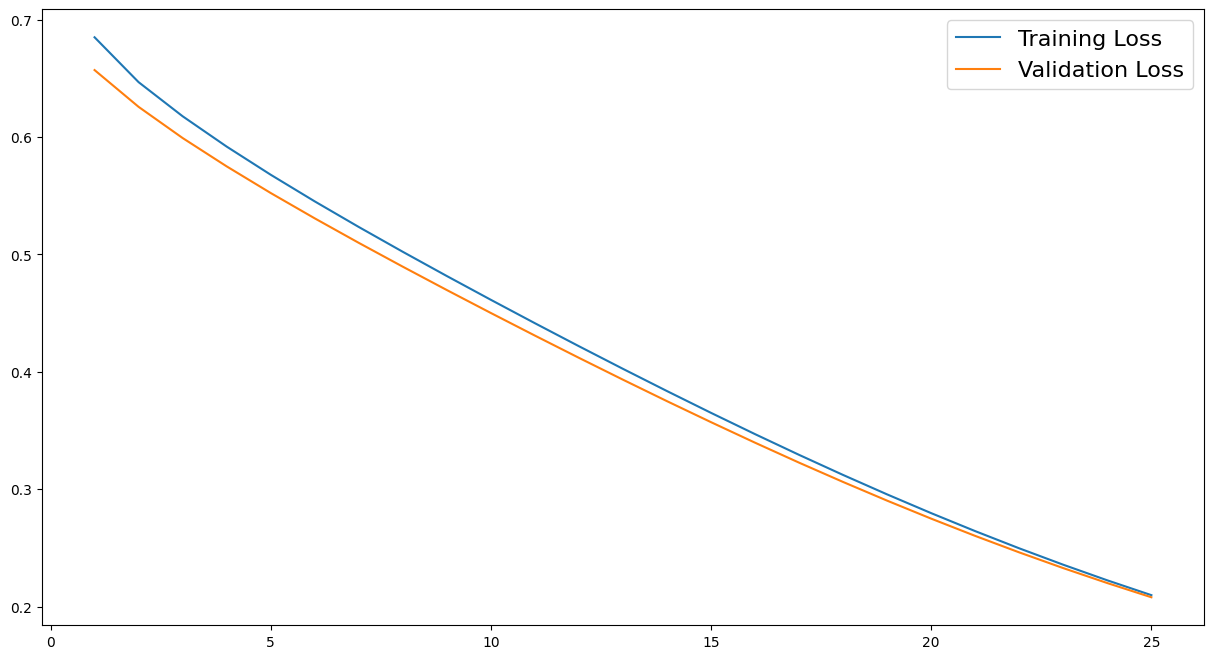

In [48]:
# Plot the learning curves of the neural network model to visualize the training and validation loss over time.
bench_loss = bench_history.history

plt.figure(figsize=(15,8))
plt.plot(np.arange(1,epochs+1), bench_loss['loss'], label='Training Loss')
plt.plot(np.arange(1,epochs+1), bench_loss['val_loss'], label='Validation Loss')
plt.legend(fontsize=16)
plt.show()

In [49]:
# Evaluate the model on the test set
loss, accuracy = bench_model.evaluate(X_test_scl, y_test_scl)

# Print the accuracy
print("Accuracy:", accuracy)

747/747 [==============================] - 2s 3ms/step - loss: 0.2050 - Accuracy: 0.9595
Accuracy: 0.9595443606376648


In [50]:
# Make predictions on the test set
y_pred = bench_model.predict(X_test_scl)

# Convert the predicted probabilities to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate precision, recall, F1 score, and AUC score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

precision = precision_score(y_test_scl, y_pred_binary)
recall = recall_score(y_test_scl, y_pred_binary)
f1 = f1_score(y_test_scl, y_pred_binary)
auc = roc_auc_score(y_test_scl, y_pred)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("AUC score:", auc)

747/747 [==============================] - 1s 2ms/step
Precision: 0.9784817692767483
Recall: 0.9123843495708394
F1 score: 0.9442778034148592
AUC score: 0.9892179803714027


In [51]:
import sklearn.metrics as metrics

#calculating the confusion matrix
confusion_mat = metrics.confusion_matrix(y_test_scl, y_pred_binary)
print(confusion_mat)

[[14727   180]
 [  786  8185]]


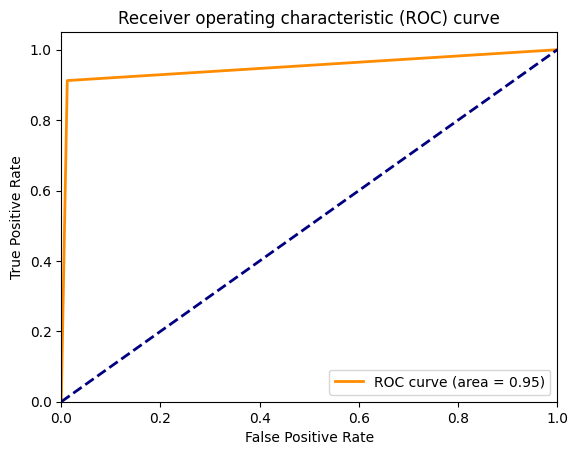

In [52]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_scl, y_pred_binary)

# compute the area under the curve (AUC)
roc_auc = metrics.auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

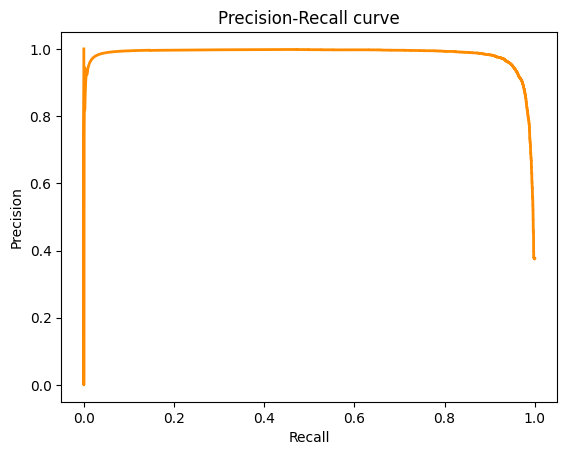

In [53]:
# compute the precision, recall, and thresholds
precision, recall, thresholds = metrics.precision_recall_curve(y_test_scl, y_pred)

# plot the precision-recall curve
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()